In [1]:
# ===============================================================
# 🔰 Step 1 — Import Libraries
# ===============================================================
import numpy as np
import pandas as pd
import os, time
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc


In [2]:
# ===============================================================
# 🔰 Step 2 — Device Setup & Data Preparation
# ===============================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ✅ Dataset path (change if needed)
DATA_DIR = "/kaggle/input/475-project/Microscopic Image Dataset of Plant-Parasitic Nematodes"

# ✅ Image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# ✅ Load dataset using ImageFolder
dataset = datasets.ImageFolder(DATA_DIR, transform=transform)

# ✅ Split 90:10 (Train:Test)
test_ratio = 0.1
test_size = int(test_ratio * len(dataset))
train_size = len(dataset) - test_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
print(f"Train: {len(train_dataset)}, Test: {len(test_dataset)}")

# ✅ Split 10% of Train as Validation
val_ratio = 0.1
val_size = int(val_ratio * len(train_dataset))
train_size_final = len(train_dataset) - val_size
train_dataset, val_dataset = random_split(train_dataset, [train_size_final, val_size])
print(f"Train: {len(train_dataset)}, Validation: {len(val_dataset)}, Test: {len(test_dataset)}")

# ✅ Dataloader setup
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


Using device: cuda
Train: 915, Test: 101
Train: 824, Validation: 91, Test: 101


In [3]:
# ===============================================================
# 🔰 Step 3 — Model: GoogLeNet (Updated for Torchvision ≥ 0.13)
# ===============================================================
from torchvision.models import googlenet, GoogLeNet_Weights

# ✅ Use modern weights API
weights = GoogLeNet_Weights.DEFAULT
model = googlenet(weights=weights)  # aux_logits=True by default

# ⚙️ Disable auxiliary classifier during training if not needed
model.aux_logits = False

# ✅ Replace final fully connected layer
num_classes = len(dataset.classes)
model.fc = nn.Linear(model.fc.in_features, num_classes)

# ✅ Move model to device
model = model.to(device)

# ✅ Loss & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 177MB/s]


In [4]:
# ===============================================================
# 🔰 Step 4 — Train & Evaluate Functions
# ===============================================================
def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in tqdm(loader, desc="Training", leave=False):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    return running_loss / total, correct / total


def evaluate(model, loader, criterion):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    all_preds, all_labels, all_probs = [], [], []
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Evaluating", leave=False):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            probs = torch.softmax(outputs, dim=1)

            correct += (preds == labels).sum().item()
            total += labels.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    return running_loss / total, correct / total, np.array(all_preds), np.array(all_labels), np.array(all_probs)


In [5]:
# ===============================================================
# 🔰 Step 5 — Training Loop
# ===============================================================
num_epochs = 50
train_losses, val_losses = [], []
train_accs, val_accs = [], []

best_val_acc = 0.0
start_time = time.time()
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_acc, _, _, _ = evaluate(model, val_loader, criterion)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_googlenet_model.pth")

end_time = time.time()
train_time = end_time - start_time
print(f"\n✅ Total training time: {train_time:.2f} sec")



Epoch 1/50


Train Loss: 2.0924, Acc: 0.3204 | Val Loss: 1.8482, Acc: 0.4835

Epoch 2/50


Train Loss: 1.4208, Acc: 0.6541 | Val Loss: 1.4588, Acc: 0.5385

Epoch 3/50


Train Loss: 0.9627, Acc: 0.7913 | Val Loss: 1.1986, Acc: 0.5824

Epoch 4/50


Train Loss: 0.6193, Acc: 0.9017 | Val Loss: 0.9796, Acc: 0.6703

Epoch 5/50


Train Loss: 0.3745, Acc: 0.9636 | Val Loss: 0.8282, Acc: 0.7253

Epoch 6/50


Train Loss: 0.2403, Acc: 0.9745 | Val Loss: 0.7196, Acc: 0.7692

Epoch 7/50


Train Loss: 0.1596, Acc: 0.9830 | Val Loss: 0.6882, Acc: 0.7692

Epoch 8/50


Train Loss: 0.1249, Acc: 0.9867 | Val Loss: 0.6566, Acc: 0.7582

Epoch 9/50


Train Loss: 0.0884, Acc: 0.9879 | Val Loss: 0.6071, Acc: 0.8022

Epoch 10/50


Train Loss: 0.0764, Acc: 0.9879 | Val Loss: 0.5847, Acc: 0.7802

Epoch 11/50


Train Loss: 0.0583, Acc: 0.9939 | Val Loss: 0.5493, Acc: 0.8242

Epoch 12/50


Train Loss: 0.0539, Acc: 1.0000 | Val Loss: 0.5778, Acc: 0.8132

Epoch 13/50


Train Loss: 0.0425, Acc: 0.9988 | Val Loss: 0.5930, Acc: 0.8132

Epoch 14/50


Train Loss: 0.0377, Acc: 1.0000 | Val Loss: 0.5685, Acc: 0.8132

Epoch 15/50


Train Loss: 0.0283, Acc: 1.0000 | Val Loss: 0.5264, Acc: 0.8242

Epoch 16/50


Train Loss: 0.0256, Acc: 1.0000 | Val Loss: 0.5436, Acc: 0.8022

Epoch 17/50


Train Loss: 0.0206, Acc: 1.0000 | Val Loss: 0.5576, Acc: 0.8132

Epoch 18/50


Train Loss: 0.0193, Acc: 1.0000 | Val Loss: 0.5732, Acc: 0.8132

Epoch 19/50


Train Loss: 0.0174, Acc: 1.0000 | Val Loss: 0.5828, Acc: 0.8022

Epoch 20/50


Train Loss: 0.0163, Acc: 1.0000 | Val Loss: 0.5558, Acc: 0.7802

Epoch 21/50


Train Loss: 0.0123, Acc: 1.0000 | Val Loss: 0.5532, Acc: 0.8022

Epoch 22/50


Train Loss: 0.0104, Acc: 1.0000 | Val Loss: 0.5903, Acc: 0.8132

Epoch 23/50


Train Loss: 0.0095, Acc: 1.0000 | Val Loss: 0.5790, Acc: 0.8022

Epoch 24/50


Train Loss: 0.0094, Acc: 1.0000 | Val Loss: 0.5441, Acc: 0.8132

Epoch 25/50


Train Loss: 0.0089, Acc: 1.0000 | Val Loss: 0.5288, Acc: 0.8242

Epoch 26/50


Train Loss: 0.0069, Acc: 1.0000 | Val Loss: 0.5342, Acc: 0.8352

Epoch 27/50


Train Loss: 0.0081, Acc: 1.0000 | Val Loss: 0.5493, Acc: 0.8571

Epoch 28/50


Train Loss: 0.0055, Acc: 1.0000 | Val Loss: 0.5345, Acc: 0.8352

Epoch 29/50


Train Loss: 0.0070, Acc: 1.0000 | Val Loss: 0.5373, Acc: 0.8022

Epoch 30/50


Train Loss: 0.0065, Acc: 1.0000 | Val Loss: 0.5520, Acc: 0.8132

Epoch 31/50


Train Loss: 0.0053, Acc: 1.0000 | Val Loss: 0.5069, Acc: 0.8352

Epoch 32/50


Train Loss: 0.0068, Acc: 1.0000 | Val Loss: 0.5646, Acc: 0.8022

Epoch 33/50


Train Loss: 0.0044, Acc: 1.0000 | Val Loss: 0.5579, Acc: 0.8022

Epoch 34/50


Train Loss: 0.0042, Acc: 1.0000 | Val Loss: 0.5302, Acc: 0.8132

Epoch 35/50


Train Loss: 0.0045, Acc: 1.0000 | Val Loss: 0.5346, Acc: 0.8352

Epoch 36/50


Train Loss: 0.0057, Acc: 0.9988 | Val Loss: 0.5285, Acc: 0.8132

Epoch 37/50


Train Loss: 0.0039, Acc: 1.0000 | Val Loss: 0.5441, Acc: 0.8132

Epoch 38/50


Train Loss: 0.0045, Acc: 1.0000 | Val Loss: 0.5506, Acc: 0.8022

Epoch 39/50


Train Loss: 0.0043, Acc: 1.0000 | Val Loss: 0.5640, Acc: 0.8242

Epoch 40/50


Train Loss: 0.0034, Acc: 1.0000 | Val Loss: 0.5613, Acc: 0.8132

Epoch 41/50


Train Loss: 0.0033, Acc: 1.0000 | Val Loss: 0.5426, Acc: 0.8132

Epoch 42/50


Train Loss: 0.0029, Acc: 1.0000 | Val Loss: 0.5490, Acc: 0.8352

Epoch 43/50


Train Loss: 0.0028, Acc: 1.0000 | Val Loss: 0.5498, Acc: 0.8242

Epoch 44/50


Train Loss: 0.0030, Acc: 1.0000 | Val Loss: 0.5702, Acc: 0.8352

Epoch 45/50


Train Loss: 0.0044, Acc: 1.0000 | Val Loss: 0.5133, Acc: 0.8462

Epoch 46/50


Train Loss: 0.0030, Acc: 1.0000 | Val Loss: 0.5027, Acc: 0.8462

Epoch 47/50


Train Loss: 0.0022, Acc: 1.0000 | Val Loss: 0.5098, Acc: 0.8462

Epoch 48/50


Train Loss: 0.0028, Acc: 1.0000 | Val Loss: 0.5394, Acc: 0.8462

Epoch 49/50


Train Loss: 0.0023, Acc: 1.0000 | Val Loss: 0.5322, Acc: 0.8462

Epoch 50/50


Train Loss: 0.0023, Acc: 1.0000 | Val Loss: 0.5622, Acc: 0.8022

✅ Total training time: 939.47 sec


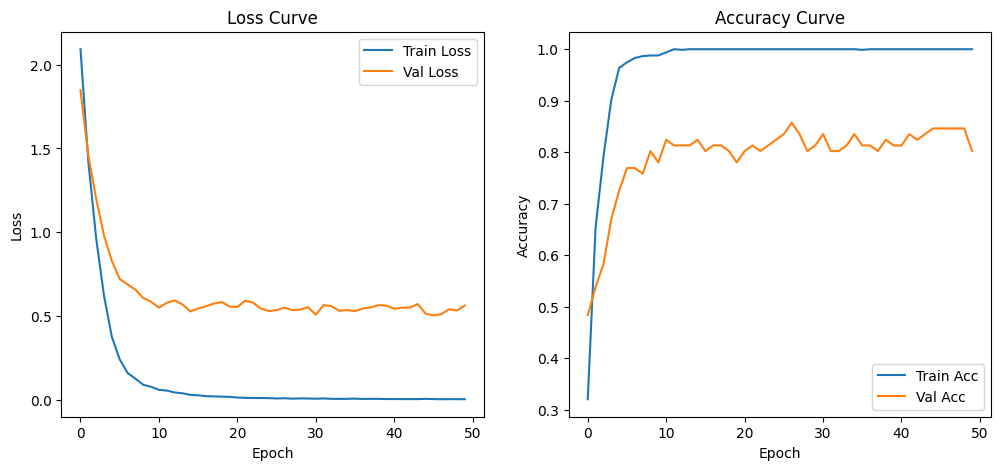

In [6]:
# ===============================================================
# 🔰 Step 6 — Plot Loss & Accuracy Curves
# ===============================================================
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accs, label="Train Acc")
plt.plot(val_accs, label="Val Acc")
plt.title("Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


In [7]:
# ===============================================================
# 🔰 Step 7 — Test Evaluation
# ===============================================================
model.load_state_dict(torch.load("best_googlenet_model.pth"))
test_start = time.time()
test_loss, test_acc, all_preds, all_labels, all_probs = evaluate(model, test_loader, criterion)
test_end = time.time()
test_time = test_end - test_start
print(f"\n✅ Test Accuracy: {test_acc*100:.2f}%")
print(f"✅ Test time: {test_time:.2f} sec")



✅ Test Accuracy: 83.17%
✅ Test time: 3.04 sec



Classification Report:
                       precision    recall  f1-score   support

  Genus Criconemoides     1.0000    0.9091    0.9524        11
Genus Helicotylenchus     0.9231    0.8000    0.8571        15
 Genus Hirschmaniella     0.7778    0.8750    0.8235         8
    Genus Hoplolaimus     0.7857    0.7333    0.7586        15
    Genus Meloidogyne     0.7619    0.8889    0.8205        18
   Genus Pratylenchus     0.6154    0.7273    0.6667        11
     Genus Radopholus     0.8333    0.8333    0.8333         6
    Genus Trichodorus     1.0000    1.0000    1.0000         4
      Genus Xiphinema     1.0000    0.8462    0.9167        13

             accuracy                         0.8317       101
            macro avg     0.8552    0.8459    0.8477       101
         weighted avg     0.8449    0.8317    0.8349       101



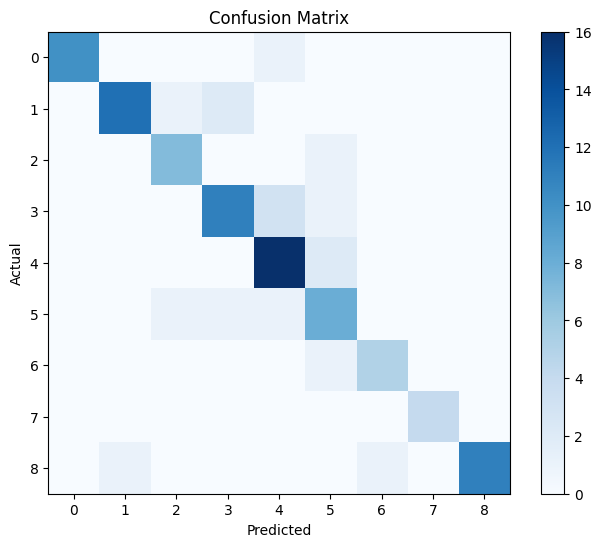


Per-class Accuracy:
Genus Criconemoides: 90.91%
Genus Helicotylenchus: 80.00%
Genus Hirschmaniella: 87.50%
Genus Hoplolaimus: 73.33%
Genus Meloidogyne: 88.89%
Genus Pratylenchus: 72.73%
Genus Radopholus: 83.33%
Genus Trichodorus: 100.00%
Genus Xiphinema: 84.62%


In [8]:
# ===============================================================
# 🔰 Step 8 — Classification Report & Confusion Matrix
# ===============================================================
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

unique_labels = sorted(list(set(all_labels)))
target_names = [dataset.classes[i] for i in unique_labels]

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, labels=unique_labels, target_names=target_names, digits=4))

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.colorbar()
plt.show()

per_class_acc = cm.diagonal() / cm.sum(axis=1)
print("\nPer-class Accuracy:")
for i, label_idx in enumerate(unique_labels):
    cls_name = dataset.classes[label_idx]
    print(f"{cls_name}: {per_class_acc[i]*100:.2f}%")


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


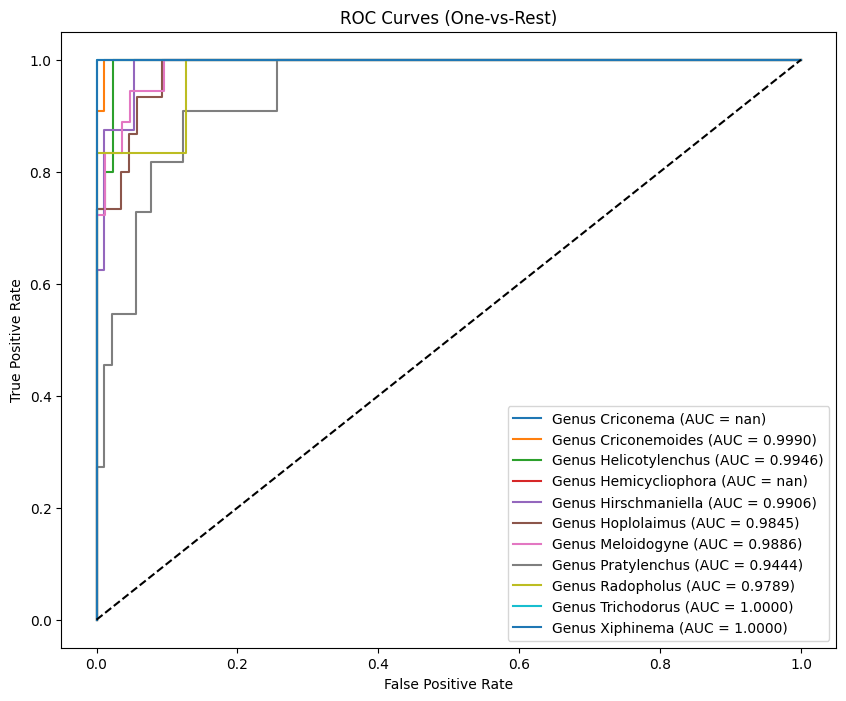

In [9]:
# ===============================================================
# 🔰 Step — ROC-AUC per class (Fixed)
# ===============================================================
import numpy as np
from sklearn.metrics import roc_curve, auc

# Ensure numpy arrays
all_labels = np.array(all_labels)
all_probs = np.array(all_probs)

plt.figure(figsize=(10,8))
for i, cls in enumerate(dataset.classes):
    # ✅ Convert to binary (1 vs rest)
    binary_labels = (all_labels == i).astype(int)
    
    # ✅ Calculate ROC curve for this class
    fpr, tpr, _ = roc_curve(binary_labels, all_probs[:, i])
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, label=f'{cls} (AUC = {roc_auc:.4f})')

plt.plot([0,1],[0,1],'k--')
plt.title("ROC Curves (One-vs-Rest)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()
